# Credit card fraud detector

## Introduction
Credit card is a very common tool for purchasing stuffs online and offline nowadays. The popularity and convenience of credit card lead to increasing usage of credit card especially in this digital era. Hence, the security and trusthworthiness of credit card company(banks,etc) can be seen as one of the most important aspect of the credit card business. So, to be able to detect credit card fraud is very important for the survival and success of credit cards company.

In this notebook, we will investigate a dataset of credit card transactions which are also labelled whether each transaction is fraud or non-fraud. We will then build a machine learning model(logistic regression) to classify the transactions. One of the most important aspect to create a good model is to make sure the choice of evaluation metric is parallel to our business goal, so, we will investigate some of the pros and cons of several commonly used metric for classification problems(in this case, binary classification). Let's dive in and try your best to read till the end because the important concepts are in the Model Evaluation section!

__Goals__ of this notebook:
1. Tackle the imbalanced dataset with resampling technique like SMOTE and Random Undersampling for Cross-validation.
2. Compare different evaluation metrics for the machine learning model and select the best metric for this problem.
3. Provide intuition to readers in the evaluation of model specifically in imbalanced binary classification problems.

For beginners who are interested in Data Visualization(EDA) and basic data cleaning, please visit the link below where I analyse the netflix movies and tv shows data:<br>
https://www.kaggle.com/oscarliujun/netflix-data-preprocessing-eda-beginner-friendly <br>
For more data cleaning and basic feature selection + engineering, look at the regression model I have to predict used vehicle prices:<br>
https://www.kaggle.com/oscarliujun/car-price-prediction-feature-engineering-91-cv

## Understanding our data

There are 30 features in this dataset, where 28 features are components from Principal Component Analysis(PCA) on the unknown features. The dataset provider has mentioned that due to privacy and security factor, only the components from PCA are provided. The other two features are Time(seconds from the first transaction) and Amount. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore')
from dataprep.eda import plot, plot_correlation, create_report, plot_missing


NumExpr defaulting to 8 threads.


In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [3]:
df.shape

(284807, 31)

In [4]:
df.duplicated().any()

True

In [5]:
df = df.drop_duplicates()

In [6]:
df.shape

(283726, 31)

## Data Visualization

I will use an automatic EDA library called DataPrep to help me generate all the relevant plots for this dataset and then analyze them. This automatic EDA helps to save me a lot of time and effort where I can focus more on the imbalanced datasets, modelling and evaluation.


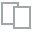
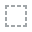
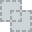
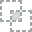
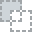
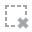
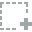
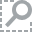
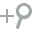
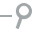
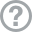
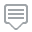
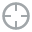
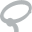
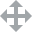
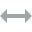
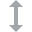
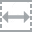
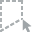
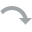
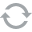
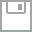
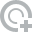
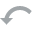
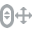
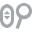
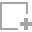
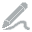
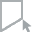
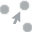
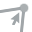
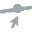

In [7]:
plot(df)

DataPrep Report
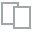
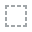
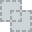
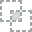
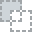
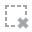
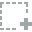
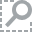
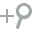
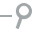
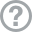
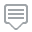
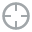
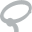
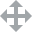
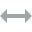
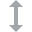
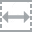
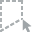
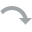
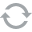
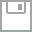
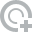
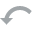
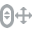
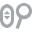
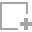
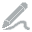
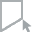
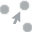
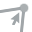
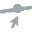

In [8]:
create_report(df)

### Some conclusions from the graphs and details above:
- 'Class' which is the labels for our transaction, '0' for non-fraud, '1' for fraud, is highly imbalanced where '0' labels constitute 99.83% while '1' only accounts for 0.17% of the transactions.
- According to the Pearson correlation matrix, there is no particular highly correlated features with respect to 'Class', the highest being V17(-0.31).
- There are no missing values in the dataset.
- As we can see from the visualization above, the components from PCA V1 - V28 are all scaled, which is the usual case of PCA. However, 'Amount' and 'Time' are not scaled, so we need to scale it to ensure the two features do not overshadow the other features. This is particularly important to create a model which is sensitive to the scaling of the features. Some of the most used scalers are: 1. Standard scaler 2. Min-max scaler 3. Robust scaler and etc.

## Building model

__Splitting the data into X(input features) and y(output class)__

In [9]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
y.value_counts()

0    283253
1       473
Name: Class, dtype: int64

__I would like to emphasize that we should always split our data first into training set and test set before scaling any of the features to prevent data leakage. When we scale the orignal dataset before splitting, the information from our test set will be leaked to the training set. The test set should be left to one corner until the whole modelling process is done. It should only be used to test the performance of the final model. We should also not tune our model based on our result with test set.__

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 59)

__I have chosen RobustScaler since it is robust to outliers.__

In [11]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

X_train['Time'] = scaler.fit_transform(X_train['Time'].values.reshape(-1,1))
X_train['Amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1,1))

X_test['Time'] = scaler.fit_transform(X_test['Time'].values.reshape(-1,1))
X_test['Amount'] = scaler.fit_transform(X_test['Amount'].values.reshape(-1,1))


### Important notes:
1. __To deal with imbalanced data, I will resample the training set with a combination of oversampling and undersampling technique(SMOTE + RandomUnderSampling). I will oversample(SMOTE) the minority class '1' to 10%, 20%, 30%, 40% and 50% of the amount of majority class '0' samples in. Then, I will undersample(RandomUnderSampler) the majority class '0' to the same amount of samples as the oversampled '1' class. Finally, after five iterations of different SMOTE level, I will choose the one which creates the best model.__<br>
2. __The reason I choose to perform both oversampling(SMOTE) and undersampling is based on certain research papers suggesting the combination will yield better result.__<br>
3. __It is also important to note that we should only resample our training dataset and not the validation set and test set. This is because resampling validation and test set will cause data leakage and create an over-optimistic model. In short, we only resample the training set for fitting our classifier(in here, Logistic Regression).__<br>
4. __This specific process must be done using a pipeline. We have to chain together the resampling technique and our classifier in order to make sure we don't resample the validation set during cross-validation which is the ultimate process to determine if we have create a model which generalizes well.__<br>
5. __I will also combine the cross-validation process with GridSearchCV to select the best hyperparameter for the Logistic Regression model.__<br>
6. __For cross-validation method, remember to use 'Stratified' version to address the imbalanced datasets(Ultimately, the data is still imbalanced, remember that the validation set is imbalanced while only the training datas will be resampled to fit a model.) Stratified version splits the datas into training and validation set so that they have the same proportion of majority to minority class.__<br>
7. __I have used 'average precision' as the evaluation metric to pick the best model. We will see why in the analysis later.__

In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

grids = []

for i in np.linspace(0.1,0.5,num=5):
    oversample = SMOTE(sampling_strategy=i)
    
    undersample = RandomUnderSampler(sampling_strategy=1)
    
    model = LogisticRegression()
    
    param_grid = {'model__C': np.logspace(-3,3, num=7)}
    
    steps = [('over',oversample),('under',undersample),('model',model)]
    
    pipeline = Pipeline(steps=steps)
    
    cv = StratifiedKFold(n_splits=5)
    
    grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1, scoring = 'average_precision')
    
    grid.fit(X_train, y_train)
    
    grids.append(grid)
    #Percentage of the majority class samples, e.g The majority '0' class has 1000 samples, then we will have 100 '1' class samples
    print("SMOTE sampling_strategy: {}".format(i))
    #Ratio of minority and majority sample, 1 means same number of '0' and '1' samples
    print("Random undersampling sampling_strategy: 1")     
    print("Best Average Precision scores:\n{}".format(grid.best_score_))
    print("Best parameter(C) for Logistic Regression:\n{}".format(grid.best_params_))
    print("\n")

SMOTE sampling_strategy: 0.1
Random undersampling sampling_strategy: 1
Best Average Precision scores:
0.7385277209574765
Best parameter(C) for Logistic Regression:
{'model__C': 0.1}


SMOTE sampling_strategy: 0.2
Random undersampling sampling_strategy: 1
Best Average Precision scores:
0.7387414539057051
Best parameter(C) for Logistic Regression:
{'model__C': 1000.0}


SMOTE sampling_strategy: 0.30000000000000004
Random undersampling sampling_strategy: 1
Best Average Precision scores:
0.7385616883304771
Best parameter(C) for Logistic Regression:
{'model__C': 1000.0}


SMOTE sampling_strategy: 0.4
Random undersampling sampling_strategy: 1
Best Average Precision scores:
0.7409939710155884
Best parameter(C) for Logistic Regression:
{'model__C': 0.1}


SMOTE sampling_strategy: 0.5
Random undersampling sampling_strategy: 1
Best Average Precision scores:
0.7398003120019849
Best parameter(C) for Logistic Regression:
{'model__C': 1000.0}




In [13]:
# Select the model with best Average Precision score from the five trained grid models.
model = grids[0]
for grid in grids:
    if grid.best_score_ > model.best_score_:
        model = grid

## Model Evaluation

### 1. Confusion Matrix
- __One of the most common tool to evaluate binary classifcation is a confusion matrix. Confusion matrix shows us the TP(True Positive), TN(True Negative) , FP(False Positive), FN(False Negative) values.__

In [14]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

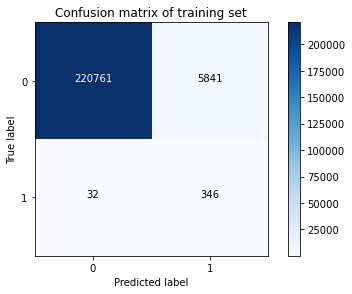

In [15]:
from sklearn.metrics import confusion_matrix
ytrain_pred = model.predict(X_train)
conf_matrix = confusion_matrix(y_train,ytrain_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix of training set')
plt.show()

- __As we can see from the confusion matrix heatmap above, the numbers of TN(220761) dominates the others. The TP (346) constitutes a very small amount compare to the FP(5841).__
- __Keep in my that our focus should be on positive cases(TP,FP,FN) only, since we are trying to deal with 'Fraud' cases only and true non-fraud case(TN) is not interesting for us.__
- __It is very obvious due to the imbalanced data, we can hardly tell if our model can detect all the frauds by just looking at confusion matrix because it only look at the 'class' labels without looking at the uncertainty probability of each predicted class value.__
- __However, you can calculate the Precision, Recall(Sensitivity), Specificity, TNR, etc using the values in the confusion matrix.__

### 2. Classification report from sklearn

In [16]:
from sklearn.metrics import classification_report

ytrain_pred = model.predict(X_train)

print(classification_report(y_train, ytrain_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    226602
           1       0.06      0.92      0.11       378

    accuracy                           0.97    226980
   macro avg       0.53      0.94      0.55    226980
weighted avg       1.00      0.97      0.99    226980



- __The sklearn metrics class provide a very useful function 'classification_report' which provides all the calculated Precision,Recall, f1-score(which we don't need to calculate manually based on the confusion matrix values).__
- __By focusing on class label '1' row only, we have all our interested details(TP,FP,FN), remember that Precision = (TP / TP + FP) and Recall = (TP / TP + FN).__
- __We have a good recall score(0.92) and very bad precision score(0.06) and f1-score(0.11). This ultimately means that, we can catch 92% of the frauds, however, we can only be sure that 6% of the frauds that we caught are really a fraud. In other words, we may falsely reject too many transactions, while be able reject most of the fraud transactions.__ 
- __Essentially, we have to make a trade-off between the ability to catch fraud transactions and the ability to make correct rejection to transactions we think are fraud.(Trade-off of Recall vs Precision)__ 
- __The precision and recall score provided in this report is calculated when the classification threshold is set at default value which is P=0.5(which means, if the predicted probability of being class '1' is more than or equal to 0.5, the sample will be predicted and labeled as '1' by the classifier).__
- __The above point is the main reason that this report is not the best metric to judge whether our model is good enough because the high majority class '0' of the dataset will skew the model while it is being fitted.For example, imagine you train your dog to 'sit' 10000 times while only training it to jump for '10' times. Surely, the dog will have the greater tendency to 'sit' rather than 'jump' when you give it some instructions. When you set the threshold of the classifier to classify the action of dog to be P=0.5, 50% of the action will be classified as 'sit' and 50% will be classified as 'jump'. However, the probability of the dog to 'sit' when given an instruction is definitely higher than 50%(P>>0.5) since it is trained 1000 times more to 'sit' than 'jump', which explains why there are so many false positive cases(low precision) when we set threshold at P=0.5 for the classification process(the dogs are classified as 'jumping' where in reality, it is 'sitting').__
- __Similarly for recall, when we have classify so many dogs as 'jump'(50% in this case) when given an instruction where in fact we are not so sure if the dog really 'jumped' since the dogs are rarely trained to 'jump'(P<<0.5), this will inflate the chance that we correctly predicted that the dog really 'jumped' since when we are not sure, we just classify it as 'jumped' and this technique can reduce the false negative('jumped' but didn't get classified as 'jumped') simply by guessing more 'jumped' dogs. Hence, recall is high(low FN).__
- __In conclusion, the precision is lower that it is supposed to be and the recall is higher than it should be when we set threshold at P=0.5(default). This shows the inflexibility of the classification report where we cannot observe the Precision and Recall value at other threshold level.__

### 3. Precision-recall Curve

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from numpy import argmax

def plot_PRC(mode):
    
    if mode == 'train':
        a = X_train
        b = y_train
        print("PR-Curve of training set")
    elif mode == 'test':
        a = X_test
        b = y_test
        print("PR-Curve of test set")
    else:
        print("Please insert 'train' or 'test' to plot PR-Curve.")
        
    y_score = model.predict_proba(a)

    y1_proba = y_score[:,1]

    fig = plt.figure(figsize=(12,6))

    precision, recall, threshold = precision_recall_curve(b, y1_proba)

    f2_score = (5 * precision * recall) / ((4 * precision) + recall)

    max_f_index = argmax(f2_score)

    aps = average_precision_score(b, y1_proba)

    print('Best Threshold=%f, F2-Score=%.3f\n' % (threshold[max_f_index], f2_score[max_f_index]))

    best_threshold = threshold[max_f_index]

    no_skill = len(b[b==1]) / len(b)

    plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')

    plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

    plt.scatter(recall[max_f_index], precision[max_f_index], marker='o', color='black', label='Best')

    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.legend()
    plt.title('UnderSampling Precision-Recall curve: \n Average Precision Score ={0:0.2f}'.format(aps),
          fontsize=16)
    return best_threshold

PR-Curve of training set
Best Threshold=0.999984, F2-Score=0.790



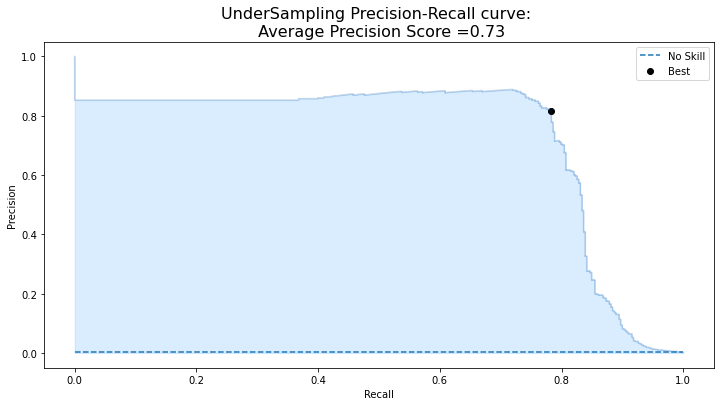

In [18]:
best_threshold = plot_PRC('train')

- __Now, here is why Precision-Recall Curve is the best choice since it plot all the Precision and Recall values for all the classification threshold(from 0 to 1) based on the predicted probability(predict_proba method of logistic regression) of each samples.__
- __The higher the AUC(Area Under Curve) of the PR Curve, the better the model is in maximizing the trade-off between precision and recall(higher recall and precision in total compare to lower PR-AUC model). Average Precision is equal to the AUC of PR Curve.__
- __The black dot is the best point(highest recall and precision) when we set the threshold at 0.999984, which is obtained by calculating the maximum F-2 score using precision and recall. F-2 score is used instead of F-1 score because we prioritize recall more than precision, so using this metric, we will find the best point which gives us higher recall by trading off precision.__
- __The F2-score for the model based on the imbalanced training data is 0.79.__
- __As a business problem(credit card business), business stakeholders can discuss and assign cost function to each fault (missed fraud detection or false alarm of fraud) and choose the best operating point that minimize the cost function based on the above PR-Curve. For example, if we prioritize catching all the frauds, we can set our operating point closer to the lower right of the curve, which yield high recall(good ability to catch fraud) but in the expense of low precision(creating many false alarm of fraud).__

__After choosing the optimal threshold from the training data to produce the best trade-off between precision and recall, we set the new threshold for our model and use it to classify the test data.__

In [19]:
y_pred_new_threshold = (model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

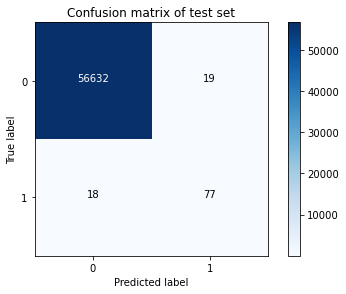

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred_new_threshold)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix
                      , classes=class_names
                      , title='Confusion matrix of test set')
plt.show()

__As we can see from the above confusion matrix, the number of False Positive(top right square) greatly reduced relative to the previous confusion matrix where we use the default threshold(P=0.5).__

In [21]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.80      0.81      0.81        95

    accuracy                           1.00     56746
   macro avg       0.90      0.91      0.90     56746
weighted avg       1.00      1.00      1.00     56746



__Now, we can confirm that by setting a new threshold at (P=0.9999), we greatly increases our trade-off between precision and recall , where we achieve 74% increase in precision while only have a decrease of 11% in recall.__

PR-Curve of test set
Best Threshold=1.000000, F2-Score=0.817



0.9999996160992831

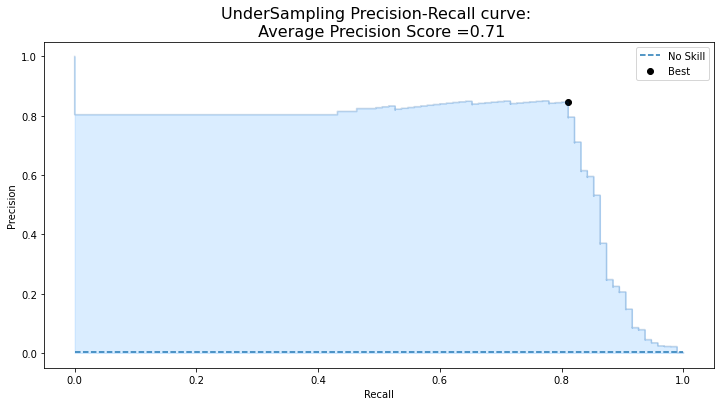

In [22]:
plot_PRC('test')

- __The Average Precision score(PR-AUC) of the test set is the same as the training sets, which tells us that our model works equally well in the training set and the test set. We also achieve a higher F2-score(0.817) in the test set at the best point where the threshold is really close to 1(0.9999999). This might mean that our model has achieved its best performance possible and we might need to retune the model or use a more complex classifier(such as Random Forest/SVM) to achieve an even higher performance(Average Precision score).__
- __To reiterate, we can set our desired recall/precision level using the PR Curve with the trade-off between precision and recall based on the curve. The best point represents the best trade-off point for precision and recall.__

### 4. ROC Curve

__One of the most widely used evaluation metric for binary classification is the ROC-AUC score which is the area under the ROC curve. However, this metric is not good and suitable for highly imbalanced data because it will produce an overly optimistic result which may misguide us into believing we have a model that perform and generalize well.__

In [23]:
from sklearn.metrics import roc_auc_score,roc_curve, precision_recall_curve, average_precision_score

y_score = model.predict_proba(X_test)

y1_proba_T = y_score[:,1]

#Creating new model to illustrate the difference of ROC Curve and PR Curve.
model1 = LogisticRegression(class_weight={0:1,1:1})
model2 = LogisticRegression(class_weight={0:1,1:10000})
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

y_score_1 = model1.predict_proba(X_test)
y1_proba_T1 = y_score_1[:,1]

y_score_2 = model2.predict_proba(X_test)
y1_proba_T2 = y_score_2[:,1]

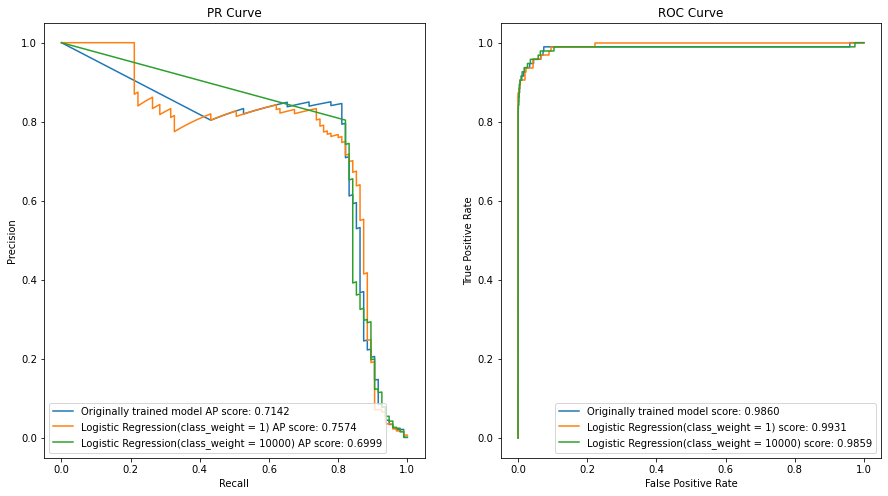

In [24]:
precision, recall, threshold = precision_recall_curve(y_test, y1_proba_T)
precision1, recall1, threshold1 = precision_recall_curve(y_test, y1_proba_T1)
precision2, recall2, threshold2 = precision_recall_curve(y_test, y1_proba_T2)

log_fpr, log_tpr, log_thresold = roc_curve(y_test, y1_proba_T)
log1_fpr, log1_tpr, log1_thresold = roc_curve(y_test, y1_proba_T1)
log2_fpr, log2_tpr, log2_thresold = roc_curve(y_test, y1_proba_T2)


fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


ax1.plot(recall, precision, label='Originally trained model AP score: {:.4f}'.format(average_precision_score(y_test, y1_proba_T)))
ax1.plot(recall1, precision1, label='Logistic Regression(class_weight = 1) AP score: {:.4f}'.format(average_precision_score(y_test, y1_proba_T1)))
ax1.plot(recall2, precision2, label='Logistic Regression(class_weight = 10000) AP score: {:.4f}'.format(average_precision_score(y_test, y1_proba_T2)))

ax2.plot(log_fpr, log_tpr, label='Originally trained model score: {:.4f}'.format(roc_auc_score(y_test, y1_proba_T)))
ax2.plot(log1_fpr, log1_tpr, label='Logistic Regression(class_weight = 1) score: {:.4f}'.format(roc_auc_score(y_test, y1_proba_T1)))
ax2.plot(log2_fpr, log2_tpr, label='Logistic Regression(class_weight = 10000) score: {:.4f}'.format(roc_auc_score(y_test, y1_proba_T2)))


ax1.legend(loc='lower left')
ax2.legend()
    

- __Two additional logistic regression model with different class_weight parameters are created to illustrate the misguiding ROC-AUC.__
- __We can see that on the ROC curve, all three models perform very having a AUC score of 0.9859(lowest) and 0.9931(highest). The difference of performance is almost undifferentiable for all the models. Consequently, if we used ROC curve and ROC-AUC to determine the performance of our model, we would be misguided into thinking our models perform very well where in fact they are not. Hence, we can say that the ROC-AUC provide an overly-optimistic evaluation of our model in classifying highly imbalanced datasets.__
- __For the Precision-recall curve, we can clearly see the differences in performances of the three models. So, this is why the Average Precision(PR-AUC) is a better metric for a highly imbalanced dataset and especially useful when our main focus is on the positive class '1' because precision and recall inform about all the positive class '1'.__

## Conclusion

We should always think carefully about the evaluation metrics we use for training our models and evaluating their performance. For binary classification problem, if our dataset is highly imbalanced and our main focus is on the positive class '1', we should always use PR-Curve instead of ROC-curve to as our evaluation metric. Confusion matrix and the classification report(which includes Precision, Recall and F-1 Score) from sklearn are not good enough to make conclusive statement about the performance of our model due to the lack of flexibility around the usage of prediction probability of the model.

Thank you very much for reading until the end! I hope you have learnt a lot from this notebook and please upvote if you find it helpful so that more people can notice this notebook! Cheers!